# Unsupervised anomaly detection with Temporian and scikit-learn

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/temporian/blob/last-release/docs/src/tutorials/anomaly_detection_unsupervised.ipynb)

In this tutorial, we use the Temporian and YDF python libraries to detect anomalies in a multivariate time series dataset.

Anomaly detection in time series, time sequences and other temporal data representations is critical in a variety of domains. For instance, it is used in manufacturing to detect equipment failure and production lines, in computer systems and by financial institutions to detect fraudulent activities, and in energy management to detect outages.

We will use the Server Machine Dataset (SMD) dataset, published as part of the [OmniAnomaly](https://github.com/NetManAIOps/OmniAnomaly/) paper, which is available in CSV files in that same repository.

This dataset contains aggregated resource usage metrics (e.g., CPU and RAM utilization, network traffic) from 28 computers in 3 data centers over a period of 5 weeks. The timestamps and feature names have been anonymized and normalized. Therefore, calendar feature engineering or the use of expert knowledge is not possible.

The dataset will be loaded, feature engineered and converted into a tabular dataset using Temporian.
Then, we will use an isolation forest model from the YDF library on this tabular data to detect anomalies.
Finally, we will evaluate the quality of our detection on the ground truth anomalies, available as part of the testing dataset.

We will first evaluate our detections both with AUC-[ROCs](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (Area Under the Receiver operating Characteristic curve) and with [AMOCs](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2815453/) (Activity Monitoring Operating Characteristic). Unlike an ROC, an AMOC takes into account the *time to detection* or *forecasting horizon* which is often critical in temporal problems like ours. If you don't know about AMOCs yet, don't worry. We will explain it.

Check out the [Supervised anomaly detection](https://temporian.readthedocs.io/en/stable/tutorials/anomaly_detection_supervised/) tutorial for a version of this notebook that trains a supervised model using the ground truth labels, which is less common in an anomaly detection setting, but can yield better performance if those are available.

## Installation and imports

In [1]:
!pip install temporian ydf scikit-learn -U -q

In [2]:
import os
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import ydf
from sklearn.metrics import roc_auc_score
import urllib.request

import temporian as tp

## Download dataset

The dataset is made of 3 groups of 8, 9, and 11 machines respectively, with names `"machine-1-1"`, ..., `"machine-3-11"`.
Let's list the machine names, and download records locally.

In [3]:
machines_per_group = [8, 9, 11]  # Full dataset
# machines_per_group = [3, 3, 3]  # Subset of data

machines = [f"machine-{group}-{id}" for group, machine in zip(range(1, 4), machines_per_group) for id in range(1, machine + 1)]
print(f"{len(machines)} machines")

28 machines


In [4]:
data_dir = Path("tmp/temporian_server_machine_dataset")
dataset_url = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset"

data_dir.mkdir(parents=True, exist_ok=True)

# Download the data and labels for each machine to its own folder
for machine in machines:
    print(f"Download data of {machine}")

    machine_dir = data_dir / machine
    machine_dir.mkdir(exist_ok=True)

    data_path = machine_dir / "data.csv"
    if not data_path.exists():
        urllib.request.urlretrieve(f"{dataset_url}/test/{machine}.txt", data_path)

    labels_path = machine_dir / "labels.csv"
    if not labels_path.exists():
         urllib.request.urlretrieve(f"{dataset_url}/test_label/{machine}.txt", labels_path)

Download data of machine-1-1
Download data of machine-1-2
Download data of machine-1-3
Download data of machine-1-4
Download data of machine-1-5
Download data of machine-1-6
Download data of machine-1-7
Download data of machine-1-8
Download data of machine-2-1
Download data of machine-2-2
Download data of machine-2-3
Download data of machine-2-4
Download data of machine-2-5
Download data of machine-2-6
Download data of machine-2-7
Download data of machine-2-8
Download data of machine-2-9
Download data of machine-3-1
Download data of machine-3-2
Download data of machine-3-3
Download data of machine-3-4
Download data of machine-3-5
Download data of machine-3-6
Download data of machine-3-7
Download data of machine-3-8
Download data of machine-3-9
Download data of machine-3-10
Download data of machine-3-11


## Load data

We use Pandas to load the data into a `DataFrame`.
Often, data requires cleaning before it can be used, and Pandas si great in this task.
However, in this dataset, the data is already cleansed, se we don't need to do any manipulation with Pandas.

In [5]:
raw_dataset_df = []

for machine in machines:
    machine_dir = data_dir / machine

    # Read the data and labels
    print(f"Load data of {machine}...", end="")
    df = pd.read_csv(machine_dir / "data.csv", header=None).add_prefix("f")
    labels = pd.read_csv(machine_dir/ "labels.csv", header=None)
    df = df.assign(label=labels)
    df["machine"] = machine
    df["timestamp"] = range(df.shape[0])
    print(f"found {df.shape[0]} events")

    raw_dataset_df.append(df)

raw_dataset_df[0].head(3)

Load data of machine-1-1...found 28479 events
Load data of machine-1-2...found 23694 events
Load data of machine-1-3...found 23703 events
Load data of machine-1-4...found 23707 events
Load data of machine-1-5...found 23706 events
Load data of machine-1-6...found 23689 events
Load data of machine-1-7...found 23697 events
Load data of machine-1-8...found 23699 events
Load data of machine-2-1...found 23694 events
Load data of machine-2-2...found 23700 events
Load data of machine-2-3...found 23689 events
Load data of machine-2-4...found 23689 events
Load data of machine-2-5...found 23689 events
Load data of machine-2-6...found 28743 events
Load data of machine-2-7...found 23696 events
Load data of machine-2-8...found 23703 events
Load data of machine-2-9...found 28722 events
Load data of machine-3-1...found 28700 events
Load data of machine-3-2...found 23703 events
Load data of machine-3-3...found 23703 events
Load data of machine-3-4...found 23687 events
Load data of machine-3-5...found 2

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f31,f32,f33,f34,f35,f36,f37,label,machine,timestamp
0,0.075269,0.065678,0.070234,0.074332,0.0,0.933333,0.274011,0.0,0.031081,0.000000,...,0.048893,0.000386,0.000034,0.064432,0.064500,0.0,0.0,0,machine-1-1,0
1,0.086022,0.080508,0.075808,0.076655,0.0,0.930769,0.274953,0.0,0.031081,0.000122,...,0.050437,0.000386,0.000022,0.065228,0.065224,0.0,0.0,0,machine-1-1,1
2,0.075269,0.064619,0.071349,0.074332,0.0,0.928205,0.274953,0.0,0.030940,0.000366,...,0.055069,0.000386,0.000045,0.067111,0.067178,0.0,0.0,0,machine-1-1,2


Next, we convert the dataset into a Temporian `EventSet`. Temporian will help data visualization and feature computation.

**Note:** Our anomaly detection model can operate directly on raw time series data, and that's how we'll begin. However, preprocessing and augmenting the temporal data (for example, calculating moving statistics or calendar events) before applying the anomaly detection model can significantly boost its performance. For example of feature engineering, check the [Feature engineering section](https://temporian.readthedocs.io/en/latest/tutorials/m5_competition/#feature-engineering) in the M5 Competition tutorial.


In [6]:
raw_dataset = tp.combine(*[tp.from_pandas(x) for x in raw_dataset_df])

# Index the EventSet according the the machine name.
raw_dataset = raw_dataset.set_index("machine")

# Cast the feature and label to a smaller dtypes to same one memory.
raw_dataset = raw_dataset.cast(tp.float32).cast({"label": tp.int32})

raw_dataset

timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,…
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,…
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,…
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,…
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2.848e+04,0.06452,0.08051,0.05017,0.04762,0,0.9077,0.258,0,0.02611,0.000611,0.1638,0.1892,0.06849,0.06964,0.1044,0.1785,…
2.848e+04,0.06452,0.05614,0.04794,0.04646,0,0.9026,0.2571,0,0.03321,0.000122,0.1434,0.1892,0.06849,0.07749,0.1264,0.1612,…
2.848e+04,0.01075,0.02966,0.04125,0.04414,0,0.8923,0.2561,0,0.03066,0.001966,0.1632,0.2162,0.08219,0.07377,0.1191,0.1815,…
timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,…
0,0.23,0.1095,0.1266,0.1338,0.2264,0.621,0.4093,0,9.3e-05,1.5e-05,0,0.00722,0,0.03695,0.003551,0.02929,…
1,0.25,0.1089,0.1271,0.134,0.2264,0.5473,0.337,0,9.3e-05,1.5e-05,0,0.009025,0,0.03926,0.004129,0.03305,…


Awesome! Seems like each machine has more than 20.000 events and 39 features (counting the "label" one).

As stated previously, all metrics seem to be anonymized and normalized to `[0, 1]`, so we won't need to take care of that ourselves.

## Data visualization

Let's take a look at some of the first machine's features.

The number of plots (39) is larger than "options.max_num_plots=3". Only the first plots will be printed.


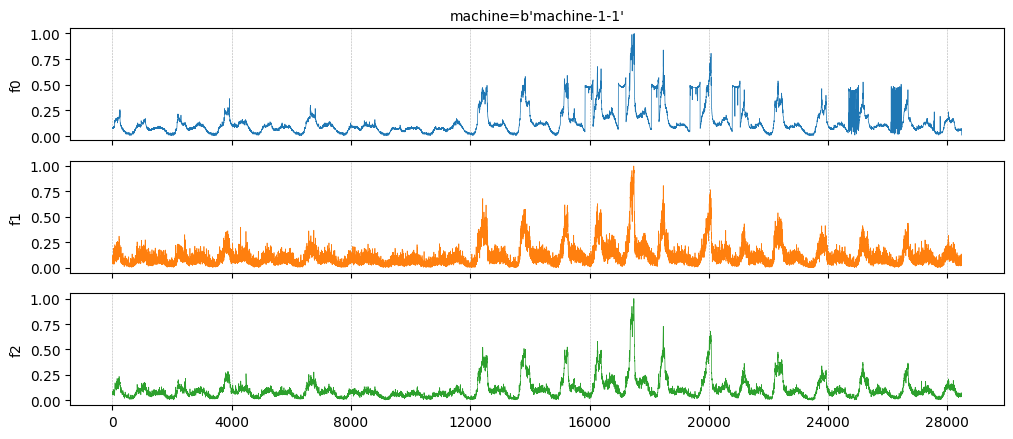

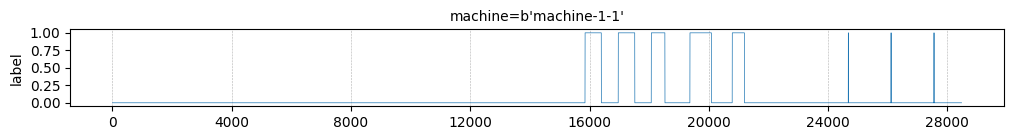

In [7]:
# Plot the first 3 features
raw_dataset.plot(indexes="machine-1-1", max_num_plots=3)

# Plot the labels
raw_dataset["label"].plot(indexes="machine-1-1")

Great! A lot to unpack here:
- It seems to be easy to understand when an anomaly occurs (label takes value of 1) by looking at the other plots. Features 11 to 14, for example, seem to be very correlated to the label.
- The data seems to have some periodicity to it.
- Some features seem empty, and we could evaluate dropping them if needed.

## Train / test split

To evaluate the quality of our anomaly detection system, we need to select some test data and remove it from the training.

One approach to splitting the dataset would be to use some of the machines for training and the rest for testing (e.g., an 80/20 split). This would be great if all machines were independent. However, if we assume dependencies between machines, this method isn't correct.

Instead, we need to split the dataset based on time. We'll use the first 80% of the time series data from all machines for training, and the remaining 20% for testing.

Note: Remember that in unsupervised anomaly detection, unlike supervised learning, the training process doesn't rely on labeled data.


We'll be creating reusable functions for each step, since we'll do some iteration over the `feature engineering -> training -> evaluation` cycle.

Train events: 560028
Test events: 148392


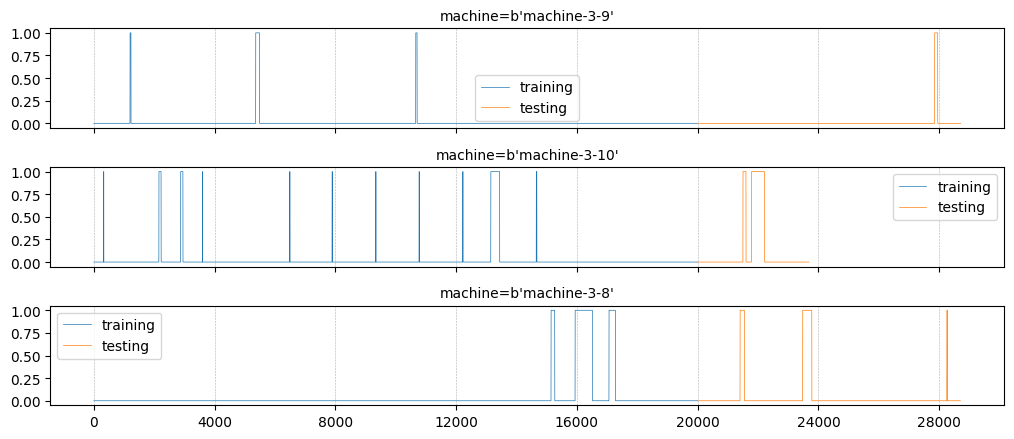

In [8]:
DROP_COLS = ["machine", "timestamp"]

def split_train_test(evset: tp.EventSet, train_cutoff: float = 20000):
    """Splits the dataset in time."""

    # Compute masks and split data based on cutoff
    train_mask = evset.timestamps() <= train_cutoff
    test_mask = ~train_mask

    # Split EventSets
    train_evset = evset.filter(train_mask)
    test_evset = evset.filter(test_mask)

    print(f"Train events: {train_evset.num_events()}")
    print(f"Test events: {test_evset.num_events()}")

    return train_evset, test_evset

# Split the data
train_dataset, test_dataset = split_train_test(raw_dataset)

# Plot the label of the training and testing set for the first 3 machines.
tp.plot((
    train_dataset["label"].rename("training"),
    test_dataset["label"].rename("testing"),
), max_num_plots=3)

## Training

Having done all that work to prepare our data, all that remains is to train our model.

**Note:** The isolation forest model is configured with `label="label"`.
This does not mean the model will be trained with the label (and isolation forest is always trained without labels).
Instead, it means we will be able to evaluate the model as a classification model later. If you don't specify `label="label"`, the model will train fine, but you won't be able to evaluate it with `model.evaluate`.

In [9]:
# Get the input feature names i.e. without the label.
feature_names = train_dataset.schema.feature_names()
feature_names.remove("label")
print("feature_names:", feature_names)

# Convert the dataset into a dictionary of numpy arrays.
train_dict = tp.to_numpy(train_dataset)

# Train the anomaly detection model.
model = ydf.IsolationForestLearner(features=feature_names).train(train_dict)

feature_names: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37']
Train model on 560028 examples
Model trained in 0:00:00.435018


It is possible to analyze the model. See the [YDF anomaly detection tutorial](https://ydf.readthedocs.io/en/latest/tutorial/anomaly_detection) for more details.
In this notebook, we will only focus on the model quality.

## Evaluation using AUC-ROC

We'll be reporting the model's ROC AUC score, which provides an aggregate measure of performance across all possible classification thresholds (since our model outputs an anomaly score for each sample, and in a real-world scenario it would be up to us to define the thershold from which we consider an event to be marked as anomalous).

Results:
         raw features
ROC AUC      0.767405
The number of plots (8) is larger than "options.max_num_plots=4". Only the first plots will be printed.


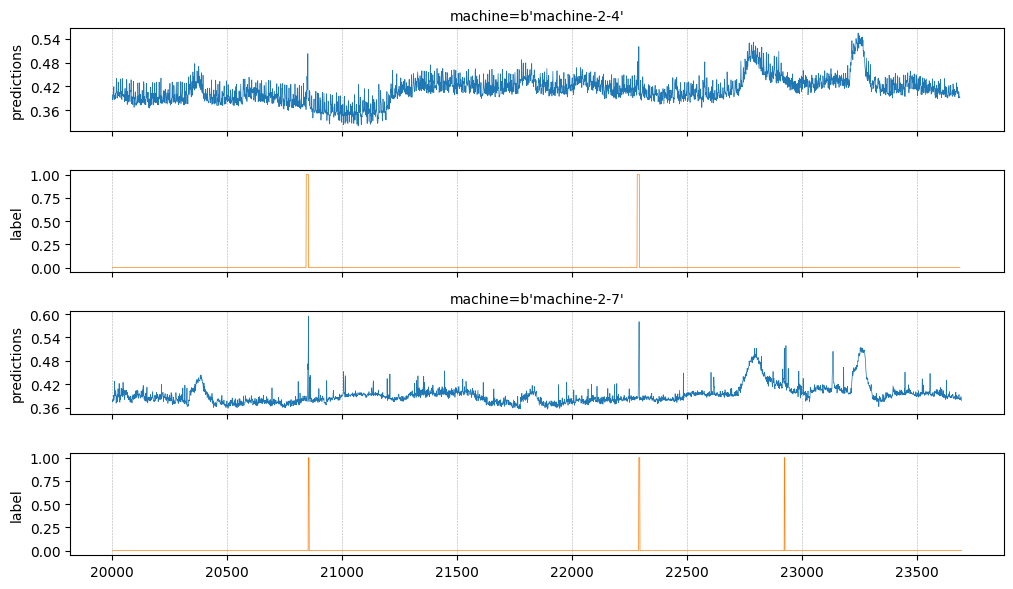

In [10]:
figsize=(20,3)

results = {}

def evaluate(model, test_dataset, name):
    """Evaluates a model on its training data and unseen test data, computing accuracy score and plotting ground truth vs predictions."""

    # Evaluate the model
    test_dict = tp.to_numpy(test_dataset)
    predictions = model.predict(test_dict)
    roc_auc = roc_auc_score(test_dict["label"], predictions)

    # Store and print the resuls
    results[name] = {"ROC AUC": roc_auc}
    print("Results:")
    print(pd.DataFrame(results))

    # Convert the predictions (stored as a numpy array) into an eventset alligned with the dataset.
    predictions_eventset = tp.event_set(
        timestamps=test_dict["timestamp"],
        features={
            "predictions": predictions,
            "machine": test_dict["machine"],
        },
        indexes=["machine"],
    )

    # Plot the anomaly detection score along side the labels.
    tp.plot([
        predictions_eventset,
        test_dataset["label"],
    ], max_num_plots=4)

evaluate(model, test_dataset, "raw features")

That's pretty decent for a first try! Our model seems to be learning.

The plotted predictions seem to be all over the place though, with the model sporadically predicting anomaly events throughout in several non-anomalous periods.

There's plenty of room for improvement, so let's kick off the feature engineering!

## Evaluation using Detection AMOC [Advanced]

A detection AMOC shows the relation between false alerts (or equivalently, the average time between false alerts) and the average time it takes to detect anomalies.

Using Temporian, we compute an AMOC as follows.

The objective is to detect anomalous events called "anomalies". An anomaly is created each time the "label" (or "target") is true.
Anomalies are detected using a numerical "signal" and a "threshold". An "alert" is created each time the signal is above the threshold.

In this dataset, two anomalies that happen close in time can be considered the same anomaly. Therefor, we apply a "shutoff" on the anomalies:
Two anomalies cannot happen within "missed_target_shutoff" of each other. A "shutoff" can also be applied on the "alert". Instead, we apply the shutoff on the "false alerts" (see next definition).

A "false alert" is an alert **not detecting** an anomaly event, i.e. an alert at time `t` without any anomaly in `[t-anomaly_window, t]`.
A "missed anomaly" is an anomaly **not detected** by any alert, i.e. an anomaly at time `t` without any alert in `[t, t+anomaly_window]`.
The "time to detection" of an anomaly at time `t` is the time between the anomaly and the first following alert in `[t, t+abnomal`y_window]`.
If not detected by an alert, the "time to detection" of an anomaly is related by the "anomaly_window" (this makes the plots easier to interpret).

Here is a summary:

![](https://raw.githubusercontent.com/google/temporian/main/docs/src/assets/amoc.svg)

We can compute an AMOC on a model or any other numerical signal. For instance, we can compute the AMOC on a feature.
We can find which one of the features `f1`and `f2` alone can best detect anomalies.


total_record_duration: 708392.0
num_machines: 28
num_anomalies: 399
total_record_duration: 708392.0
num_machines: 28
num_anomalies: 399


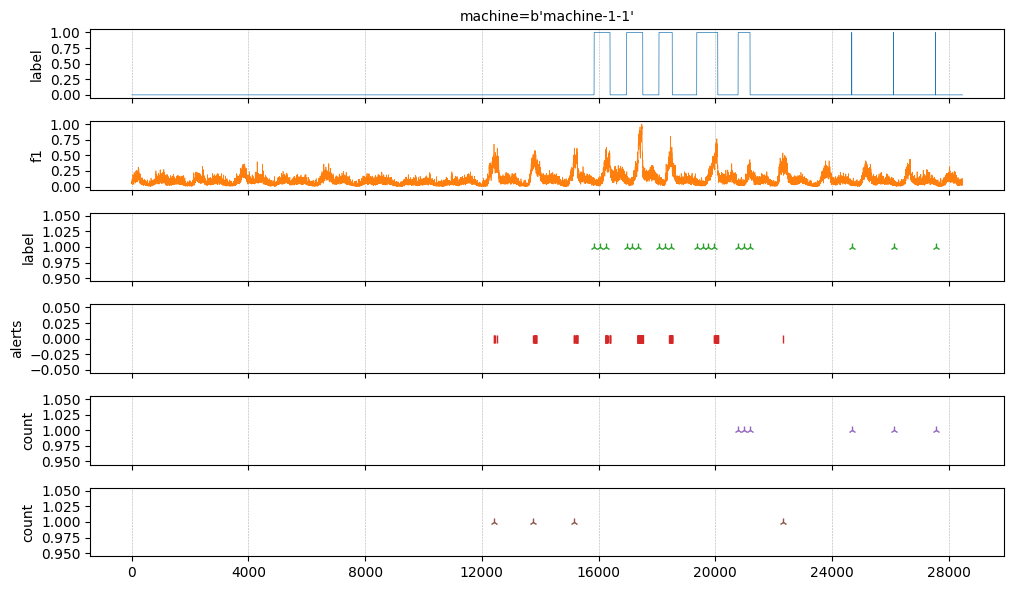

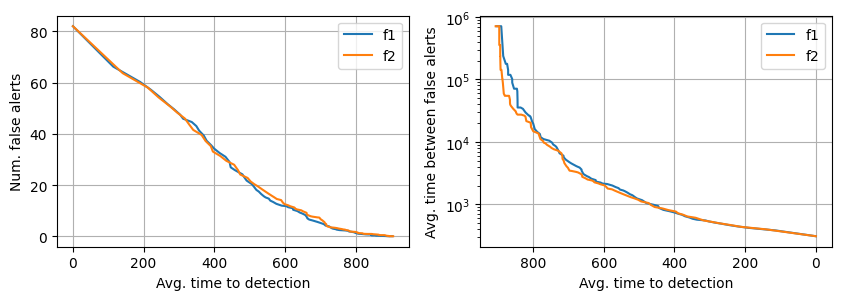

In [11]:
# @title Define "compute_detection_amoc" and "plot_detection_amoc" to compute and plot amocs.

from dataclasses import dataclass
from typing import Optional, Dict, List
import matplotlib.pyplot as plt

@dataclass
class ThresholdEval:
    """Model metric for each threshold value applied on the score."""

    threshold: float
    num_false_alerts: int
    num_missed_anomalies: int
    average_time_to_detection: float
    total_record_duration: float
    num_machines: int

def compute_detection_amoc(target : tp.EventSet,
                   signal : tp.EventSet,
                   detection_thresholds: List[float] = np.linspace(0,1,100, dtype=np.float32).tolist(),
                   anomaly_window : float = 1000.,
                   anomaly_shutoff : float = 200.,
                   false_alert_shutoff : float = 200.,
                   plot_first: bool = True,
                  ) -> List[ThresholdEval]:
    """Computes a detection AMOC.

    Args:
        target: A boolean feature defining an anomaly to detect.
        signal: A numerical feature detecting recent anomalies. A signal above a threshold becomes an alert.
        detection_thresholds: List of evaluated detection thresholds applied on the "signal".
        anomaly_window: For how long an anomaly can be detected.
        anomaly_shutoff: Minimum distance between two anomalies.
        false_alert_shutoff: Minimum distance between two missed alerts.
        plot_first: Plot the alerts, anomalies of the first index and the mid-threshold.
    """

    # List the anomalies
    anomalies = target.cast(tp.bool_).filter()
    anomalies = anomalies.filter_moving_count(anomaly_shutoff)

    # Final timestamp used to collect all the metrics.
    end_of_records = signal.end()
    end_of_records_global = end_of_records.drop_index(keep=False).end()

    def sum_by_index(evset) -> int:
        """Sums of the last value of a feature in all the indexes."""
        assert len(evset.schema.features) == 1 # There should be only one feature

        return float(evset.drop_index(keep=False).cumsum(sampling=end_of_records_global).get_arbitrary_index_data().features[0][0])

    # The duration of record in each index is the time distance between the first and last event.
    record_duration = signal.begin().since_last(sampling=signal.end())
    total_record_duration = sum_by_index(record_duration)
    print("total_record_duration:",total_record_duration)

    # There is one index per machine
    num_machines = len(target.data)
    print("num_machines:",num_machines)

    num_anomalies = int(anomalies.drop_index(keep=False).moving_count(np.inf, sampling=end_of_records_global).get_arbitrary_index_data().features[0][0])
    print("num_anomalies:",num_anomalies)

    # Can also be computed this way:
    assert num_anomalies == np.sum([len(machine.timestamps) for key, machine in anomalies.data.items()])

    amoc = []

    for threshold_idx, threshold in enumerate(detection_thresholds):
        is_mid_threshold = threshold_idx == (len(detection_thresholds)//2)

        alerts = (signal >= threshold).filter()[[]]

        # False alerts
        false_alerts = anomalies.moving_count(anomaly_window, sampling=alerts).equal(0).filter()
        false_alerts = false_alerts.filter_moving_count(false_alert_shutoff)
        num_false_alerts = false_alerts.moving_count(np.inf, sampling=end_of_records)

        # Missed targets
        missed_anomalies = alerts.moving_count(anomaly_window, sampling=anomalies.lag(anomaly_window)).equal(0).filter().leak(anomaly_window)
        missed_anomalies = missed_anomalies.filter_moving_count(false_alert_shutoff)
        num_missed_anomalies = missed_anomalies.moving_count(np.inf, sampling=end_of_records)

        # Time to detection
        time_to_detection = anomalies.until_next(sampling=alerts, timeout=anomaly_window)
        # Set the time to detection of non detected anomalies with the maximum anomaly_window.
        time_to_detection = time_to_detection.isnan().where(anomaly_window, time_to_detection)
        # Note: Some machines don't have alerts
        sum_time_to_detection = time_to_detection.cumsum(sampling=end_of_records)

        if plot_first and is_mid_threshold:
            anomalies.name = "anomalies"
            alerts.name = "alerts"
            missed_anomalies.name = "missed_anomalies"
            false_alerts.name = "false_alerts"
            tp.plot([
                target,
                signal,
                anomalies,
                alerts,
                missed_anomalies,
                false_alerts
                ],
                    indexes="machine-1-1",
                   height_per_plot_px=100)

        amoc.append(ThresholdEval(
            threshold=threshold,
            num_false_alerts=sum_by_index(num_false_alerts) / num_machines,
            num_missed_anomalies=sum_by_index(num_missed_anomalies) / num_machines,
            average_time_to_detection=sum_by_index(sum_time_to_detection) / num_anomalies,
            total_record_duration=total_record_duration / num_machines,
            num_machines=num_machines,
        ))

    return amoc

def plot_detection_amoc(amoc_dict: Dict[str, List[ThresholdEval]]):

    # Plot the AMOC and other related plots
    fig, axs = plt.subplots(1, 2, figsize=(5*2, 3), squeeze=False)

    for name, amoc in amoc_dict.items():
        ax = axs[0,0]
        ax.plot([e.average_time_to_detection for e in amoc],
                [e.num_false_alerts for e in amoc],
               label=name)

        ax = axs[0,1]
        ax.plot([e.average_time_to_detection for e in amoc if e.num_false_alerts != 0],
                [e.total_record_duration / e.num_false_alerts for e in amoc if e.num_false_alerts != 0],
               label=name)

    ax = axs[0,0]
    ax.set_xlabel("Avg. time to detection")
    ax.set_ylabel("Num. false alerts")
    ax.legend()
    ax.grid(True)

    ax = axs[0,1]
    ax.set_xlabel("Avg. time to detection")
    ax.set_ylabel("Avg. time between false alerts")
    ax.set_yscale("log")
    ax.invert_xaxis()
    ax.legend()
    ax.grid(True)

amoc_f1 = compute_detection_amoc(raw_dataset["label"], raw_dataset["f1"])
amoc_f2 = compute_detection_amoc(raw_dataset["label"], raw_dataset["f2"], plot_first=False)

plot_detection_amoc({
    "f1":amoc_f1,
    "f2":amoc_f2,
})

We can see that both features performs relatively equally.
For instance, with an average time to detection of 400 time-units, both features generate approximately ~30 false alerts for each machine.

What about our detection model now?

total_record_duration: 148364.0
num_machines: 28
num_anomalies: 78


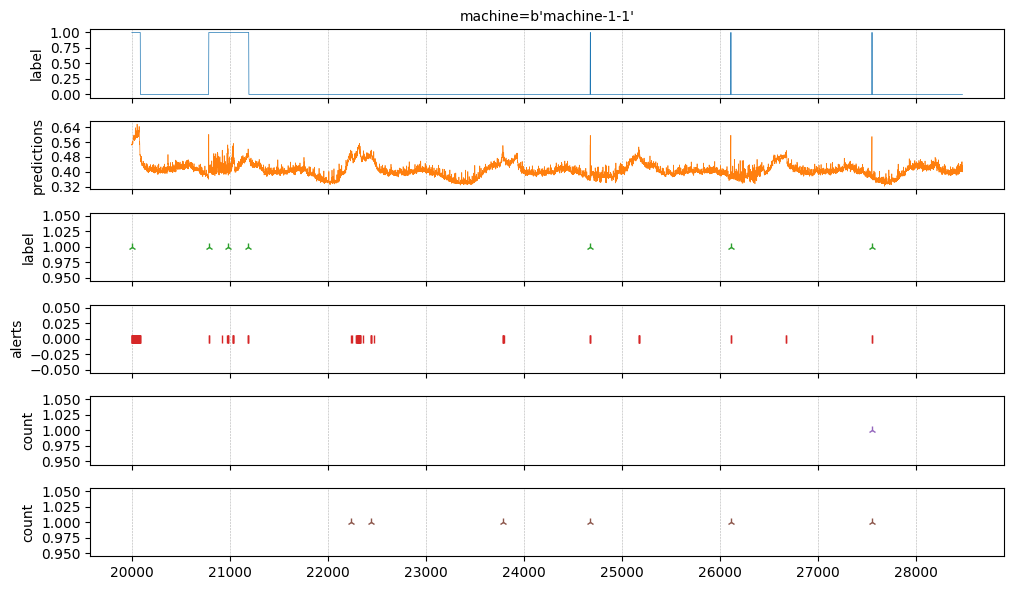

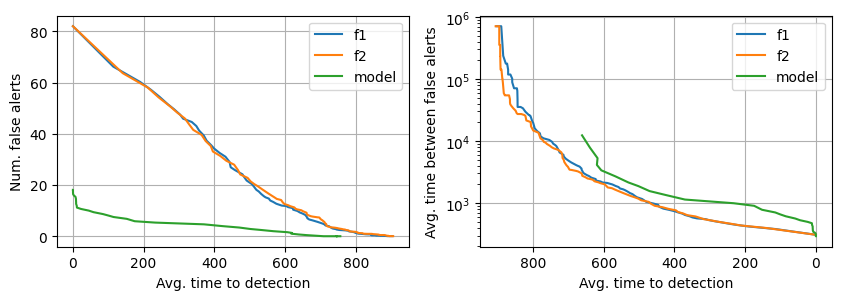

In [12]:
test_dict = tp.to_numpy(test_dataset)
pred_evset = tp.event_set(
        timestamps=test_dict["timestamp"],
        features={
            "predictions": model.predict(test_dict),
            "label": test_dict["label"],
            "machine": test_dict["machine"],
        },
        indexes=["machine"],
    )

amoc_model_raw_features = compute_detection_amoc(pred_evset["label"], pred_evset["predictions"])

plot_detection_amoc({
    "f1":amoc_f1,
    "f2":amoc_f2,
    "model": amoc_model_raw_features,
})

The model is **much** better than the features alone. This is expected, but it is a good check to do :).

For example, the model is able to detect the anomalies within 200 time-units while raising ~8 false alerts.
By comparison, using `f1`or `f2`alone will generate ~55 false alerts for the same time to detection


## Wrapping up

In this notebook we learned how to perform feature engineering and visualization using Temporian, applying it to a real-world anomaly detection use case.
